### Variational Autoencoders for non-supervised intrusion detection

We train the variational autoencoders with 'normal' traffic <br>
We test it with 'attack' traffic and obtain result <br>
<br>
PCA Analysis of the results <br>
Visualization analysis on how the MAE splits the result <br>

\


In [ ]:
# Pointer to check
# https://github.com/a-agmon/anomaly_det/blob/master/AnomalyDetectorsVAE-KDD-original.ipynb
# https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

2022-03-11 19:58:12.010346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-11 19:58:12.010369: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# Hyperparameters

NOISE = 0.2        # amount of noise to add to exercise
NETWORK = 'ANN'    # or ANN
THRESHOLD = 1      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.05 # threshold for deterministic

In [ ]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 

In [5]:
path = './data/Tommy_morris/gas_dataset.csv'

cols_dataset = ['response_address' ,'command_memory','response_memory','command_memory_count' , 'response_memory_count',
'comm_read_function' ,'comm_write_fun' , 'resp_read_fun' , 'resp_write_fun' ,
'sub_function' , 'command_length' , 'resp_length' , 'gain'  , 'reset' ,
'deadband' , 'cycletime' ,'rate' , 'setpoint' , 'control_mode' , 'control_scheme' ,
'pump','solenoid','crc_rate','measurement' , 'time' ,'result' ]


gas_df = pd.read_csv(path, delimiter = ',', header=None,names=cols_dataset)
gas_df.shape

(97019, 26)

In [6]:
gas_df['result'].value_counts()

0    61156
2    15466
4     7637
7     6805
1     2763
6     1837
3      782
5      573
Name: result, dtype: int64

In [7]:


gas_df = gas_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(gas_df)



In [8]:
labels = gas_df['result'].to_numpy() 

ATTACK_LABEL = 1
NORMAL_LABEL = 0

norm_samples = df_scaled[labels == NORMAL_LABEL]  # normal data
attack_samples = df_scaled[labels != NORMAL_LABEL]  # attack data

norm_labels = labels[labels == NORMAL_LABEL]
attack_labels = labels[labels != NORMAL_LABEL]
print('normal size labels', norm_labels.shape)
print('attack size labels',attack_labels.shape)

normal size labels (61156,)
attack size labels (35863,)


In [9]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.8 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0
print('shape X_train', X_train.shape)
print('shape X_test', X_test.shape)
print('shape y_test', y_test.shape)

shape X_train (48924, 26)
shape X_test (24464, 26)
shape y_test (24464,)


In [10]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [11]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
intermediate_dim = 512

In [13]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
x      = Dense(intermediate_dim/2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 26)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          13824       ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 256)          131328      ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 8)            2056        ['dense_1[0][0]']                
                                                                                            

In [14]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
x             = Dense(intermediate_dim/2, activation='relu')(x)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 8)]               0         
                                                                 
 dense_2 (Dense)             (None, 512)               4608      
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 26)                6682      
                                                                 
Total params: 142,618
Trainable params: 142,618
Non-trainable params: 0
_________________________________________________________________


In [15]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [16]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [17]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=50,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 26)]              0         
                                                                 
 encoder (Functional)        (None, 8)                 149264    
                                                                 
 decoder (Functional)        (None, 26)                142618    
                                                                 
Total params: 291,882
Trainable params: 291,882
Non-trainable params: 0
_________________________________________________________________
Train on 48924 samples
Epoch 1/50


2022-03-11 19:58:28.713443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 19:58:28.714124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-11 19:58:28.714200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-11 19:58:28.714266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-11 19:58:28.716429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

48924/48924 [==============================] - 1s 30us/sample - loss: 472.2027
Epoch 2/50
48924/48924 [==============================] - 1s 25us/sample - loss: 88.5698
Epoch 3/50
48924/48924 [==============================] - 1s 25us/sample - loss: 32.4308
Epoch 4/50
48924/48924 [==============================] - 1s 24us/sample - loss: 14.3718
Epoch 5/50
48924/48924 [==============================] - 1s 25us/sample - loss: 11.3179
Epoch 6/50
48924/48924 [==============================] - 1s 25us/sample - loss: 10.0218
Epoch 7/50
48924/48924 [==============================] - 1s 25us/sample - loss: 8.9969
Epoch 8/50
48924/48924 [==============================] - 1s 24us/sample - loss: 8.2596
Epoch 9/50
48924/48924 [==============================] - 1s 24us/sample - loss: 7.6785
Epoch 10/50
48924/48924 [==============================] - 1s 24us/sample - loss: 7.2756
Epoch 11/50
48924/48924 [==============================] - 1s 24us/sample - loss: 6.9224
Epoch 12/50
48924/48924 [=========

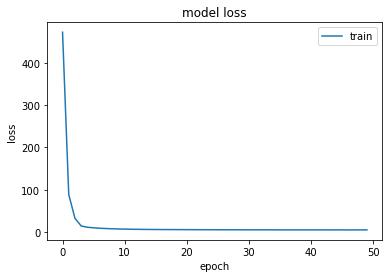

In [18]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [19]:
X_train_pred = vae_model.predict(X_train)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [20]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)
error_thresh = np.quantile(mae_vector, 0.95)
print(error_thresh)

Avg error 0.0020897557255139315
median error 0.0017255437457604906
99Q: 0.006912036854900908
setting threshold on 0.006912036854900908 
0.004444556883578579


In [21]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total anomalies',len(anomalies))
print(np.count_nonzero(anomalies))

print('total y_test',len(y_test))
print(np.count_nonzero(y_test))

total anomalies 24464
13066
total y_test 24464
12232


In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     12232
         1.0       0.94      1.00      0.97     12232

    accuracy                           0.97     24464
   macro avg       0.97      0.97      0.97     24464
weighted avg       0.97      0.97      0.97     24464



In [23]:
X_pred.shape

(24464, 26)

In [24]:
X_encoded = encoder.predict(X_test)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

In [26]:
X_transform

array([[ 1.4091302 ,  0.2591058 ],
       [ 2.9929283 , -0.66790515],
       [ 2.132692  ,  1.2126323 ],
       ...,
       [-2.5460851 ,  0.5638451 ],
       [-1.6033105 ,  0.32713673],
       [-1.5391332 , -1.2259244 ]], dtype=float32)

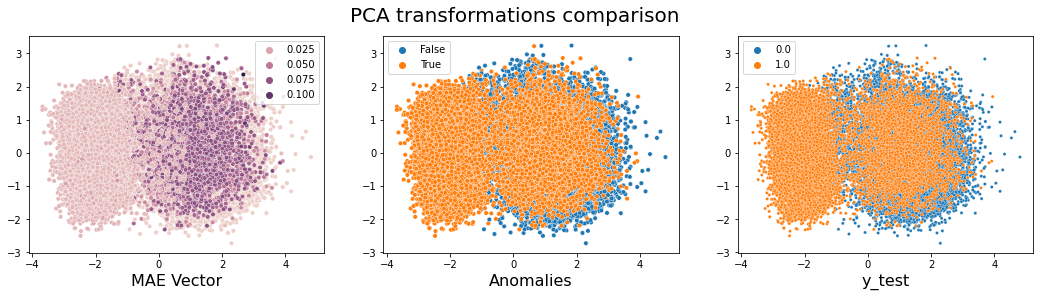

In [27]:
# comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
plt.show()

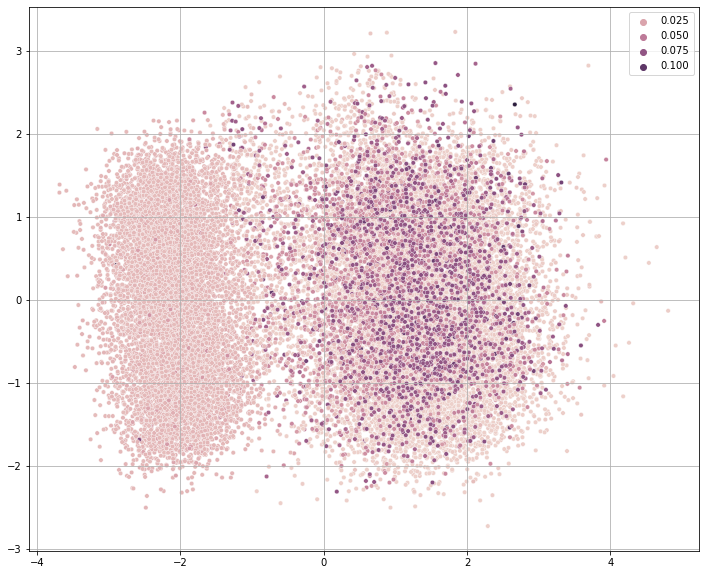

In [28]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

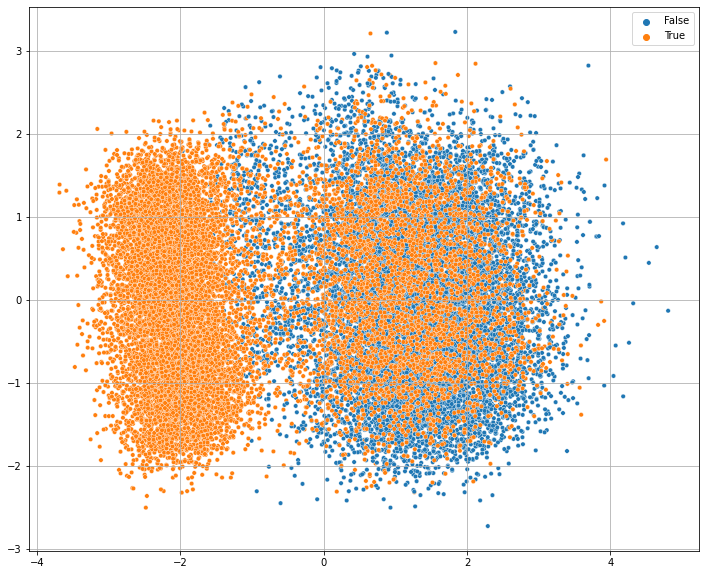

In [29]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

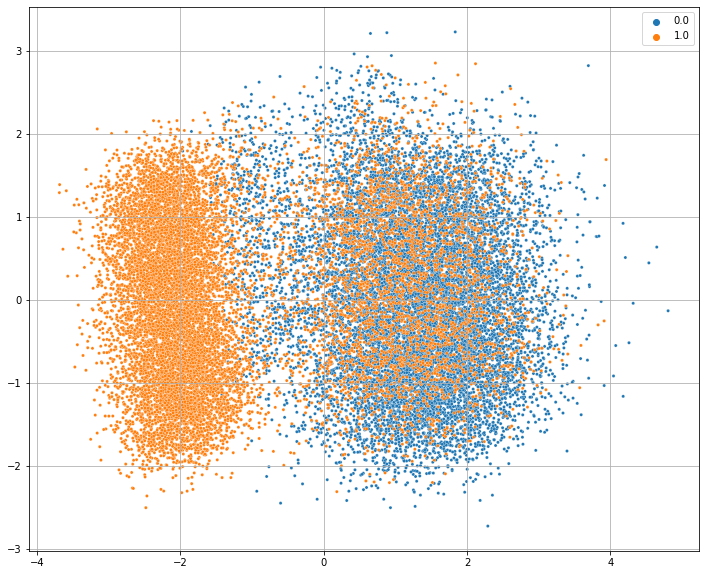

In [30]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [31]:
X_pred.shape

(24464, 26)

0.004444556883578579


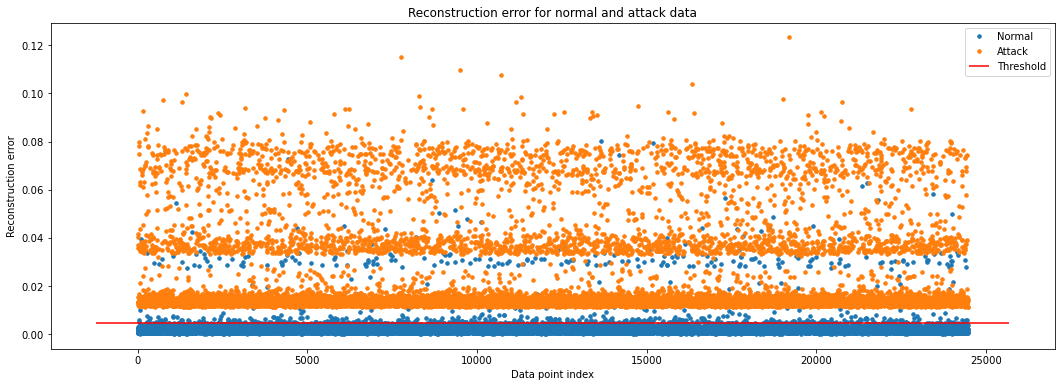

In [32]:
# figure
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
print(error_thresh)
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()